## 1


### The report is written using Jupyter Notebook.

### I chose the temperature data about 網走 (ABASHIRI), and most of the code refers to the materials given by the teacher. I am sorry that  I am only good at R , not python, at the moment.

In [49]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

class Kalman_Filter(object):
  def __init__(self, qq, rr):
    self.q = qq*qq
    self.r = rr*rr

  def init_kalman(self, xmean_init, xstd_init ):
    self.m = 1
#    self.m = 10
    self.x = np.zeros((self.m))
    self.x[:] = xmean_init
    self.var = xstd_init**2 * np.eye((self.m))

    self.Fmat = np.zeros((self.m, self.m))
    self.Qmat = np.zeros((self.m,self.m))
    self.Fmat[0,0] = 1.0
    self.Qmat[0,0] = self.q
#    for i in range(self.m-1):
#      self.Fmat[i+1,i] = 1.0
    
  def prediction(self):
    self.x = self.Fmat.dot(self.x)
    self.var = self.Fmat.dot(self.var.dot(self.Fmat.T)) + self.Qmat
    return self.x, self.var

  def filtering(self, ydata):
    kalman_gain = self.var[:,0] / (self.var[0,0] + self.r )
    self.x = self.x + kalman_gain * (ydata - self.x[0])
    self.var = self.var - np.reshape(kalman_gain, (self.m,1)).dot(np.reshape(self.var[:,0], (1,self.m)))
    return self.x, self.var

In [50]:

data = pd.read_csv('/Users/sami/Downloads/ABASHIRI.csv',header=None)
data.to_csv("ABASHIRI.dat", header=None,index=None,sep = " ")
data = np.loadtxt( 'ABASHIRI.dat' )
data[:,1].var()

0.6076097126308755

In [225]:
q = 0.6
r = 1.0

td = data[:,0]
yd = data[:,1]
nt = len(yd)

Filter = Kalman_Filter(q, r)
Filter.init_kalman(10.0, 10.0 )
lag = Filter.m - 1

xmeanarr1 = np.zeros((nt))
xstdarr1 = np.zeros((nt))

for k in range(0,nt):
  xpmean, xpvar = Filter.prediction()
  xmean, xvar = Filter.filtering( yd[k] )

  xmeanarr1[k] = xmean[0]
  xstdarr1[k] = np.sqrt(xvar[0,0])
#  if k >= lag:
#    xmeanarr[k-lag] = xmean[lag]
#    xstdarr[k-lag] = np.sqrt(xvar[lag,lag])
    
#for k in range(lag):
#  xmeanarr[nt-k-1] = xmean[k]
#  xstdarr[nt-k-1] = np.sqrt(xvar[k,k])

xlarr1 = xmeanarr1 - xstdarr1
xuarr1 = xmeanarr1 + xstdarr1

dic1= {"year": td, 
             "prediction": xmeanarr1}
KF_predict=pd.DataFrame(dic1)
KF_predict

,year,prediction
0,1889.0,7.425651
1,1890.0,7.066219
2,1891.0,6.696083
3,1892.0,6.423419
4,1893.0,6.008091
...,...,...
129,2018.0,7.014196
130,2019.0,7.186426
131,2020.0,7.326411
132,2021.0,7.493188


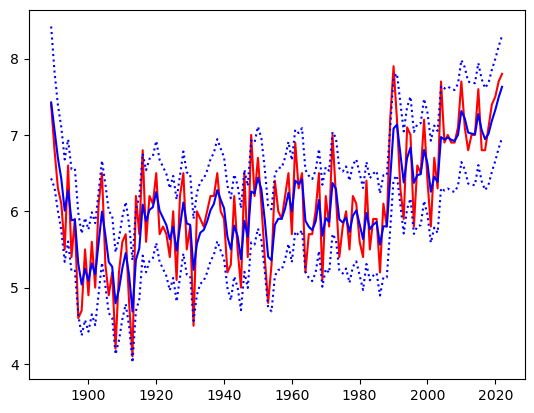

In [227]:
plt.plot( td, yd, color='red' )
plt.plot( td, xmeanarr1, color='blue' )
plt.plot( td, xuarr1, color='blue', linestyle='dotted' )
plt.plot( td, xlarr1, color='blue', linestyle='dotted' )
plt.show()

## 2


In [228]:
import numpy as np
import numpy.random as ran
import matplotlib.pylab as plt
import csv

Ndim = 10
Nobs = 1

class State:
  def __init__(self):
    self.x = np.zeros(( Ndim ))


class System:
  def proceed(self, xst):
    xst.x[1:Ndim] = xst.x[0:(Ndim-1)]
    xst.x[0] = xst.x[1]

In [229]:
# 擬似観測データ生成用
class Observation:
  def __init__(self, rsig):
    rarr = rsig * np.ones(( Nobs ))
    self.Rmat = np.diag( rsig*rarr )
    self.Rsqrt = np.diag( rarr )
    self.Rinv = np.diag( 1.0 / (rsig*rarr) )
    self.Hmat = np.zeros((Nobs, Ndim))
    self.Hmat[0,0] = 1.0

  def hobs(self, xst):
    yob = self.Hmat.dot(xst.x)
    return yob

  def obs_perturbation(self):
    return self.Rsqrt.dot(ran.randn(Nobs))

In [230]:
import copy

class Filter(object):
  def __init__( self, xens, sysmodel, obsmodel ):
    self.nptcls = len(xens)
    self.sym = sysmodel
    self.obm = obsmodel
    weq = 1.0 / self.nptcls
    self.weight = np.full((self.nptcls), weq)

  def prediction(self, xens):
    for i in range(self.nptcls):
      self.sym.proceed( xens[i] )

  def enkf(self, xens, ydata):
    Ymat = np.zeros((Nobs, self.nptcls))
    for i in range(self.nptcls):
      Ymat[:,i] = self.obm.hobs(xens[i])

    ymean = np.reshape(np.mean(Ymat, 1), (Nobs,1))
    DY = (Ymat - ymean)/np.sqrt(self.nptcls - 1.0)
    YYmat = DY.dot(DY.T) + self.obm.Rmat

    Yinov = np.reshape(ydata, (Nobs,1)) - Ymat
    for i in range(self.nptcls):
      Yinov[:,i] += self.obm.obs_perturbation()

## W[:,i] = Y^T (YY^T + R)^{-1}(y - Hx^{(i)} + w^{(i)})
    Wmat = (DY.T).dot((np.linalg.inv(YYmat)).dot(Yinov))

    dx = copy.deepcopy( xens )
    xensmean = State( )
    for i in range(self.nptcls):
      xensmean.x += self.weight[i] * xens[i].x

    dx = copy.deepcopy( xens )
    for i in range(self.nptcls):
      dx[i].x = (dx[i].x - xensmean.x)/(np.sqrt(self.nptcls - 1.0))

    for i in range(self.nptcls):
      for j in range(self.nptcls):
        xens[i].x += dx[j].x*Wmat[j,i]


  def estimation(self, xens):
    xensmean = State( )
    xensvar = State( )

    for i in range(self.nptcls):
      xensmean.x += self.weight[i] * xens[i].x
      xensvar.x += self.weight[i] * xens[i].x**2
    xensvar.x = xensvar.x - xensmean.x**2

    return xensmean,xensvar

In [231]:
Npt = 40 # Ensemble size
q = 0.6
robs = 1.0

xp = [None] * Npt
for i in range(Npt):
  xp[i] = State()
  xp[i].x[0] = ran.normal( 10.0, 10.0 )

xsysm = System( )
obmodel = Observation( robs )
filt = Filter( xp, xsysm, obmodel )


data = np.loadtxt( 'ABASHIRI.dat' )
td = data[:,0]
yobs = data[:,1]
nt = len(yobs)
lag = Ndim - 1

xmeanarr2 = np.zeros((nt))
xstdarr2 = np.zeros((nt))

## EnKF loop
for k in range(nt):
  filt.prediction( xp )
  for i in range(Npt):
    xp[i].x[0] += q*ran.normal( )

  filt.enkf( xp, yobs[k:(k+1)] )
  xmean,xvar = filt.estimation( xp )
  xmeanarr2[k] = xmean.x[0]
  xstdarr2[k] = np.sqrt(xvar.x[0])

#  if k >= lag:
#    xmeanarr[k-lag] = xmean.x[lag]
#    xstdarr[k-lag] = np.sqrt(xvar.x[lag])
## EnKF loop end

#for k in range(lag):
#  xmeanarr[nt-k-1] = xmean.x[k]
#  xstdarr[nt-k-1] = np.sqrt(xvar.x[k])

xlarr2 = xmeanarr2 - xstdarr2
xuarr2 = xmeanarr2 + xstdarr2

dic2= {"year": td, 
             "prediction": xmeanarr2}
EKF_predict=pd.DataFrame(dic2)
EKF_predict

,year,prediction
0,1889.0,7.458350
1,1890.0,7.030558
2,1891.0,6.508746
3,1892.0,6.455540
4,1893.0,6.249531
...,...,...
129,2018.0,6.819099
130,2019.0,7.027967
131,2020.0,7.238631
132,2021.0,7.432248


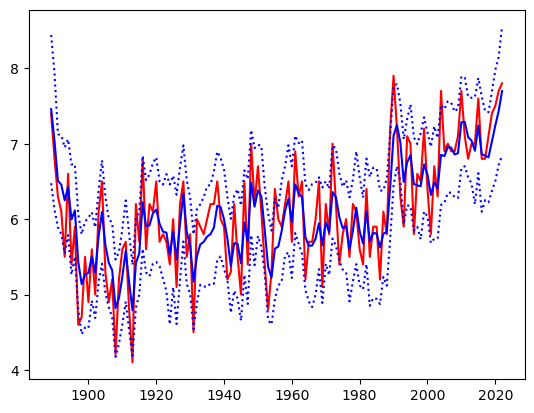

In [232]:
## Plot

plt.plot( td, yobs, color='red' )
plt.plot( td, xmeanarr2, color='blue' )
plt.plot( td, xuarr2, color='blue', linestyle='dotted' )
plt.plot( td, xlarr2, color='blue', linestyle='dotted' )
plt.show()

# 3


### I get the hint from:https://stackoverflow.com/questions/48868545/solving-and-animating-a-lorenz-system-using-rk4.

/var/folders/j2/148n1zfn7lv9n6p9y18995480000gn/T/ipykernel_55898/1139390193.py:71: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


<Figure size 800x800 with 0 Axes>

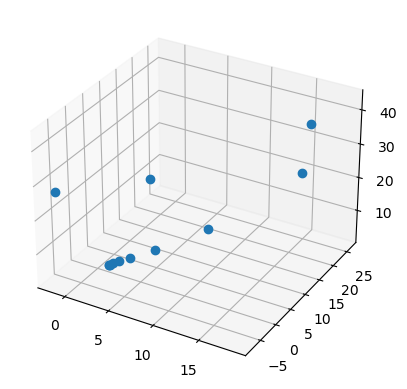

array([ 1.        ,  1.        ,  1.01256719,  1.10724173,  1.40972375,
        2.13325682,  3.7358356 ,  7.29377301, 14.45358622, 18.54213993,
        8.53655883, -1.67409727])

In [233]:
#animate a Lorenz system using RK4

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.animation as animation

#Differential equations of a Lorenz System
def X(x, y, s):
    return s * (y - x)

def Y(x, y, z, r):
    return (-x) * z + r * x - y

def Z(x, y, z, b):
    return x * y - b * z

#RK4 for the differential equations
def RK4(x, y, z, s, r, b, h):
    k_1 = X(x, y, s)
    l_1 = Y(x, y, z, r)
    m_1 = Z(x, y, z, b)

    k_2 = X((x + k_1 * h * 0.5), (y + l_1 * h * 0.5), s)
    l_2 = Y((x + k_1 * h * 0.5), (y + l_1 * h * 0.5), (z + m_1 * h * 0.5), r)
    m_2 = Z((x + k_1 * h * 0.5), (y + l_1 * h * 0.5), (z + m_1 * h * 0.5), b)

    k_3 = X((x + k_2 * h * 0.5), (y + l_2 * h * 0.5), s)
    l_3 = Y((x + k_2 * h * 0.5), (y + l_2 * h * 0.5), (z + m_2 * h * 0.5), r)
    m_3 = Z((x + k_2 * h * 0.5), (y + l_2 * h * 0.5), (z + m_2 * h * 0.5), b)

    k_4 = X((x + k_3 * h), (y + l_3 * h), s)
    l_4 = Y((x + k_3 * h), (y + l_3 * h), (z + m_3 * h), r)
    m_4 = Z((x + k_3 * h), (y + l_3 * h), (z + m_3 * h), b)

    x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * h * (1/6)
    y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * h * (1/6)
    z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * h * (1/6)

    return (x, y, z)

#Initial values and Parameters
x_0, y_0, z_0 = 1, 1, 1
s, r, b = 10, 28, 8/3

#RK4 iteration
x_list = [x_0]
y_list = [y_0]
z_list = [z_0]
h_list=[]
h = 0
i = 0

while h <= 0.1:
    x = x_list[i]
    y = y_list[i]
    z = z_list[i]
 
    position = RK4(x, y, z, s, r, b, h)

    x_list.append(position[0])
    y_list.append(position[1])
    z_list.append(position[2])
    h_list.append(h)
    h += 0.01
    i += 1
  
#plotten
plt.figure(figsize=(8,8))
fig = plt.figure()
ax = fig.gca(projection = '3d')

x_array = np.array(x_list)
y_array = np.array(y_list)
z_array = np.array(z_list)
h_array = np.array(h_list)


ax.plot(x_array, y_array, z_array,'o') 

plt.show()
x_array

In [234]:
h_array

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [235]:
# using EKF
from numpy import random
np.random.seed(42)
xk = x_array[:1]+random.normal(size=11)

Npt = 20 # Ensemble size
q = 0.01
robs = 1.0


xp = [None] * Npt
for i in range(Npt):
  xp[i] = State()
  xp[i].x[0] = ran.normal( 10.0, 10.0 )

xsysm = System( )
obmodel = Observation( robs )
filt = Filter( xp, xsysm, obmodel )


td = h_array
yobs = xk
nt = len(yobs)
lag = Ndim - 1

xmeanarr3 = np.zeros((nt))
xstdarr3 = np.zeros((nt))

## EnKF loop
for k in range(nt):
  filt.prediction( xp )
  for i in range(Npt):
    xp[i].x[0] += q*ran.normal( )

  filt.enkf( xp, yobs[k:(k+1)] )
  xmean,xvar = filt.estimation( xp )
  xmeanarr3[k] = xmean.x[0]
  xstdarr3[k] = np.sqrt(xvar.x[0])

xlarr3 = xmeanarr3 - xstdarr3
xuarr3 = xmeanarr3 + xstdarr3

dic3= {"time": td, 
       "simulation":xk,
             "prediction": xmeanarr3}
EKF_predict3=pd.DataFrame(dic3)
EKF_predict3

,time,simulation,prediction
0,0.00,1.496714,1.638962
1,0.01,0.861736,1.284903
2,0.02,1.647689,1.352807
3,0.03,2.523030,1.595212
4,0.04,0.765847,1.456482
5,0.05,0.765863,1.338766
6,0.06,2.579213,1.541254
7,0.07,1.767435,1.533166
8,0.08,0.530526,1.463316
9,0.09,1.542560,1.498447


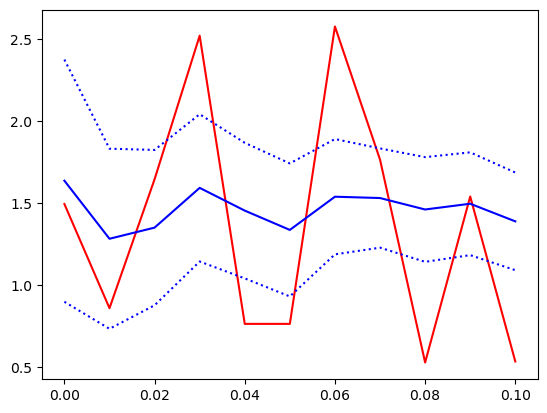

In [236]:
## Plot
plt.style.use('default')
plt.plot( td, yobs, color='red' )
plt.plot( td, xmeanarr3, color='blue' )
plt.plot( td, xuarr3, color='blue', linestyle='dotted' )
plt.plot( td, xlarr3, color='blue', linestyle='dotted' )
plt.show()